# Table of Contents
* [Interpolating multiple sets of polygons with `tobler`](#Interpolating-multiple-sets-of-polygons-with-tobler)
	* [First steps](#First-steps)
	* [Visualizing these two set of polygons](#Visualizing-these-two-set-of-polygons)
* [Harmonizing the geodataframes with different methods](#Harmonizing-the-geodataframes-with-different-methods)
	* [Area Interpolation Method](#Area-Interpolation-Method)
	* [Raster Land Cover Area method: National Land Cover Dataset (NLCD)](#Raster-Land-Cover-Area-method:-National-Land-Cover-Dataset-%28NLCD%29)
* [Comparing both methods in terms of the values generated for all variables](#Comparing-both-methods-in-terms-of-the-values-generated-for-all-variables)


# Interpolating multiple sets of polygons with `tobler`

This notebook guides you through to one of the main functionalities in `tobler` which is the areal interpolations functions. This functions allow users to pass a set of different set of polygons, such as a different set of US census tracts from different years that were modified.

In [1]:
from tobler.area_weighted import *
from tobler import harmonize

import os
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from quilt.data.spatialucr import census
from shapely.wkb import loads

import warnings
warnings.filterwarnings("ignore")

import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt
%matplotlib inline

## First steps

This example uses all census data that the user must provide your own copy of the external database. A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/geosnap/blob/master/examples/01_getting_started.ipynb. After the user download the zip files, you must provide the path to these files.

In [2]:
import geosnap
from geosnap.data.data import store_ltdb

#os.chdir('path_to_zipfiles')
os.chdir('C:\\Users\\renan\\Desktop\\osnap_data')

sample = "LTDB_Std_All_Sample.zip"
full = "LTDB_Std_All_fullcount.zip"

store_ltdb(sample = sample, fullcount = full)

Hashing: 100%|██████████| 300M/300M [00:01<00:00, 238MB/s] 


In [3]:
df = geosnap.data.data_store.ltdb

- The Philadelphia County is the code '42101' (State Code + County Code): https://en.wikipedia.org/wiki/List_of_counties_in_Pennsylvania


- `n_total_pop` (total population), `n_white_under_15` (total population of white people under 15 years old) and `p_white_under_15` (percentage of white people under 15 years old of a specific region) are variables that are present in all census data to be harmonized. Therefore, a good set of variables to be used as as example for multiple harmonization of both extensive and intensive types.

In [4]:
df['geoid'] = df.index
df['state'] = df['geoid'].str[0:2]
variables = ['geoid', 'n_total_pop', 'n_white_under_15', 'p_white_under_15']

df_phili_2010 = df[(df['year'] == 2010) & (df.geoid.str[0:5] == '42101')][variables]

We need to get the raw census data of 2000 since the geoid of the data and the polygons to merge.

In [5]:
df_2000 = geosnap.data.data_store.tracts_2000()[variables]
df_2000['geoid'] = [str(item).zfill(11) for item in list(df_2000.geoid.astype(str))]
df_phili_2000 = df_2000[df_2000.geoid.str[0:5] == '42101']

Getting the raw census tracts polygons for 1990:

In [6]:
aux = census.tracts_1990()
aux['geometry'] = aux.wkb.apply(lambda x: loads(x, hex=True))
aux = aux.drop(['wkb', 'index'], axis = 1)
gdf_1990 = gpd.GeoDataFrame(aux)
gdf_1990['year'] = '1990'
gdf_1990.head()

,geoid,geometry,year
0,01023009567,"POLYGON ((-88.414064 32.179518, -88.414226 32....",1990
1,01023009568,"POLYGON ((-88.32355099999999 32.02982, -88.324...",1990
2,01023009569,"POLYGON ((-88.457246 31.81052, -88.458158 31.8...",1990
3,01023009570,"POLYGON ((-88.188908 31.698461, -88.194 31.698...",1990
0,01037009610,"POLYGON ((-86.09742900000001 32.912974, -86.09...",1990


... and now, 2000:

In [7]:
aux = census.tracts_2000()
aux['geometry'] = aux.wkb.apply(lambda x: loads(x, hex=True))
aux = aux.drop(['wkb'], axis = 1)
gdf_2000 = gpd.GeoDataFrame(aux)
gdf_2000['year'] = '2000'
gdf_2000.head()

,geoid,geometry,year
0,01071950100,"POLYGON ((-85.659972 34.755957, -85.660201 34....",2000
1,01071950200,"POLYGON ((-85.771604 34.917734, -85.772938 34....",2000
2,01071950300,"POLYGON ((-86.02624400000001 34.783033, -86.02...",2000
3,01071950400,"POLYGON ((-86.32297199999999 34.741224, -86.32...",2000
4,01071950500,"POLYGON ((-86.171466 34.621673, -86.1737300000...",2000


Merging the data with the original tract polygons of 2000:

In [8]:
full_phili_2000 = gdf_2000.merge(df_phili_2000, on = 'geoid')

## Visualizing these two set of polygons

(-75.29683499999999, -74.939665, 39.85221, 40.15119)

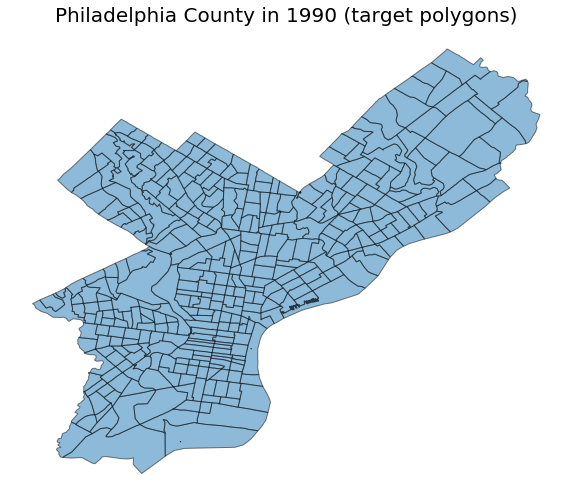

In [9]:
phili_1990 = gdf_1990[gdf_1990.geoid.str[0:5] == '42101']
ax = phili_1990.plot(figsize = (10,10), alpha = 0.5, edgecolor = 'black')
ax.set_title("Philadelphia County in 1990 (target polygons)", fontsize = 20)
plt.axis('off')

(-75.29646379999998, -74.9392762, 39.8523232, 40.1512988)

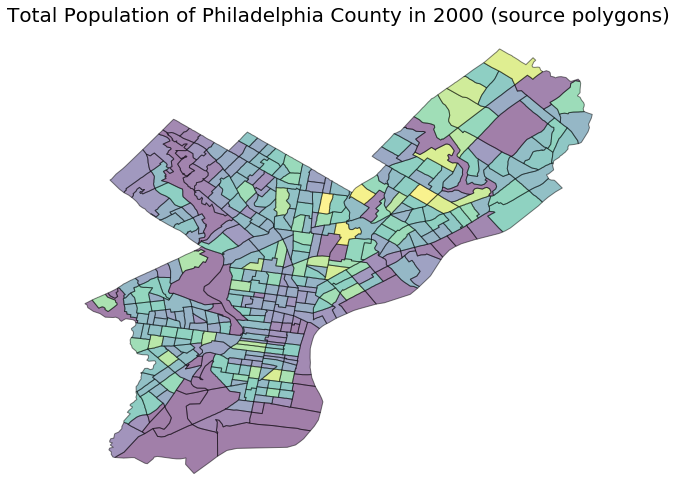

In [10]:
ax = full_phili_2000.plot(column = 'n_total_pop', figsize = (10,10), alpha = 0.5, edgecolor = 'black')
ax.set_title("Total Population of Philadelphia County in 2000 (source polygons)", fontsize = 20)
plt.axis('off')

**Although these maps look similar to each other, they actually do not represent the same set of polygons. There are some differences if we look closer.** This is confirmed as the number of tracts of each year is different:

In [11]:
print('N. of tracts in 1990 (target): {} \nN. of tracts in 2000 (source): {}'.format(len(phili_1990), len(full_phili_2000)))

N. of tracts in 1990 (target): 367 
N. of tracts in 2000 (source): 381


Since we'd like to harmonize different set of tracts, we need to make sure that all input are in the same Coordinate Reference System (CRS):

In [12]:
phili_1990.crs = full_phili_2000.crs = {'init': 'epsg:4326'}

# Harmonizing the geodataframes with different methods 

## Area Interpolation Method

In [13]:
result_area = area_interpolate_binning(full_phili_2000,
                                       phili_1990,
                                       extensive_variables = ['n_total_pop', 'n_white_under_15'],
                                       intensive_variables = ['p_white_under_15'])

nan values in variable: p_white_under_15, replacing with 0.0


In [14]:
result_area[0].shape # Extensive Values interpolated

(367, 2)

In [15]:
result_area[1].shape # Intensive Values interpolated

(367, 1)

The output of the function is a tuple with values with all interpolated variables separated by extensive and intensive classes of variables. You can append these values in target polygons:

In [16]:
phili_1990['area_interpolated_n_total_pop'] = result_area[0][:,0]
phili_1990['area_interpolated_n_white_under_15'] = result_area[0][:,1]
phili_1990['area_interpolated_p_white_under_15'] = result_area[1][:,0]
phili_1990.head()

,geoid,geometry,year,area_interpolated_n_total_pop,area_interpolated_n_white_under_15,area_interpolated_p_white_under_15
0,42101000001,"POLYGON ((-75.1478 39.9486, -75.14919999999999...",1990,2692.555587,37.926295,1.316683
1,42101000002,"POLYGON ((-75.15900000000001 39.9536, -75.1594...",1990,1364.565915,6.785932,0.460593
2,42101000003,"POLYGON ((-75.17749999999999 39.9551, -75.1776...",1990,2656.200162,97.529551,3.765605
3,42101000004,"POLYGON ((-75.1782 39.9523, -75.17919999999999...",1990,4289.591198,40.594815,0.938504
4,42101000005,"POLYGON ((-75.15170000000001 39.9517, -75.152 ...",1990,1295.854409,2.704585,0.134690


## Raster Land Cover Area method: National Land Cover Dataset (NLCD)

This method is similar to the area method previously. However, instead of using the actual polygon area, it uses only the area of the polygon that are considered "inhabited" according to the land type aiming to improve the estimates. In this method the proxy for the polygon area is actually the number of considered "populated pixels".

The first step to use these functionalities is to read a file from NLCD. We chose to use the data from Pennsylvania state like in example of the GeoPySpark homepage and then download the file with these commands:

```
curl -o /tmp/NLCD2011_LC_Pennsylvania.zip "https://s3-us-west-2.amazonaws.com/prd-tnm/StagedProducts/NLCD/data/2011/landcover/states/NLCD2011_LC_Pennsylvania.zip?ORIG=513_SBDDG"

unzip -d /tmp /tmp/NLCD2011_LC_Pennsylvania.zip
```

Then in the same directory as this notebook do

```
ln -s /tmp/NLCD2011_LC_Pennsylvania.tif
```

Now, you need to specify the file path of the unzipped file that would look like something like this:

In [17]:
raster_filepath = '~/NLCD2011_LC_Pennsylvania.tif'
raster_filepath = 'C:\\Users\\renan\\Desktop\\harmonization_osnap\\NLCD2011_LC_Pennsylvania\\NLCD2011_LC_Pennsylvania.tif'

Just for the sake of visualization, we read the raster file:

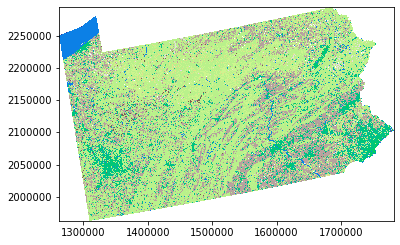

In [18]:
penn_raster = rasterio.open(raster_filepath)
show(penn_raster, cmap='terrain')

In [19]:
# help(area_tables_raster)

aux_area_tables = area_tables_raster(full_phili_2000, 
                                     phili_1990, 
                                     raster_filepath)

Now we use the `area_interpolate` function:

In [20]:
result_raster = area_interpolate(full_phili_2000,
                                 phili_1990,
                                 extensive_variables = ['n_total_pop', 'n_white_under_15'],
                                 intensive_variables = ['p_white_under_15'],
                                 tables = aux_area_tables)

In [21]:
result_raster[0].shape # Extensive Values interpolated

(367, 2)

In [22]:
result_raster[1].shape # Intensive Values interpolated

(367, 1)

Similarly, we can append these values in the dataset

In [23]:
phili_1990['raster_interpolated_n_total_pop'] = result_raster[0][:,0]
phili_1990['raster_interpolated_n_white_under_15'] = result_raster[0][:,1]
phili_1990['raster_interpolated_p_white_under_15'] = result_raster[1][:,0]
phili_1990.head()

,geoid,geometry,year,area_interpolated_n_total_pop,area_interpolated_n_white_under_15,area_interpolated_p_white_under_15,raster_interpolated_n_total_pop,raster_interpolated_n_white_under_15,raster_interpolated_p_white_under_15
0,42101000001,"POLYGON ((-75.1478 39.9486, -75.14919999999999...",1990,2692.555587,37.926295,1.316683,2666.167205,37.135867,1.307928
1,42101000002,"POLYGON ((-75.15900000000001 39.9536, -75.1594...",1990,1364.565915,6.785932,0.460593,1391.014345,6.948442,0.461179
2,42101000003,"POLYGON ((-75.17749999999999 39.9551, -75.1776...",1990,2656.200162,97.529551,3.765605,2694.413349,98.151988,3.749538
3,42101000004,"POLYGON ((-75.1782 39.9523, -75.17919999999999...",1990,4289.591198,40.594815,0.938504,4295.455408,40.858452,0.943535
4,42101000005,"POLYGON ((-75.15170000000001 39.9517, -75.152 ...",1990,1295.854409,2.704585,0.134690,1303.176395,2.765546,0.136141


# Comparing both methods in terms of the values generated for all variables

As we can see in the graphs below, both methods produce similar results.

Text(0, 0.5, 'NLCD (area)')

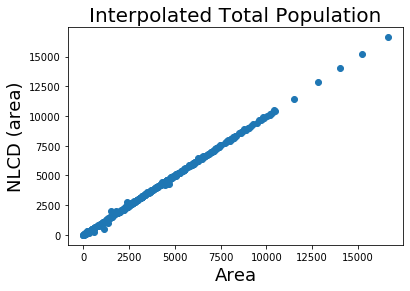

In [24]:
plt.scatter(phili_1990.area_interpolated_n_total_pop, phili_1990.raster_interpolated_n_total_pop)
plt.title('Interpolated Total Population', fontsize = 20)
plt.xlabel('Area', fontsize = 18)
plt.ylabel('NLCD (area)', fontsize = 18)

Text(0, 0.5, 'NLCD (area)')

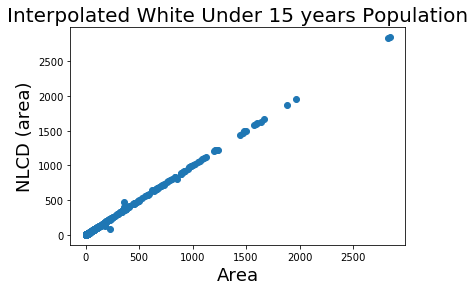

In [25]:
plt.scatter(phili_1990.area_interpolated_n_white_under_15, phili_1990.raster_interpolated_n_white_under_15)
plt.title('Interpolated White Under 15 years Population', fontsize = 20)
plt.xlabel('Area', fontsize = 18)
plt.ylabel('NLCD (area)', fontsize = 18)

Text(0, 0.5, 'NLCD (area)')

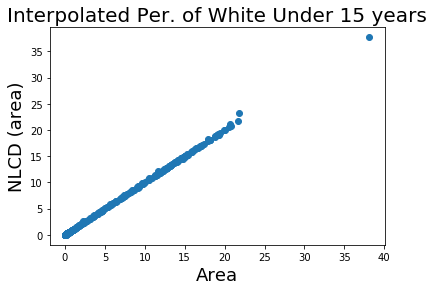

In [26]:
plt.scatter(phili_1990.area_interpolated_p_white_under_15, phili_1990.raster_interpolated_p_white_under_15)
plt.title('Interpolated Per. of White Under 15 years', fontsize = 20)
plt.xlabel('Area', fontsize = 18)
plt.ylabel('NLCD (area)', fontsize = 18)